In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.datasets import load_digits

In [2]:
from PIL import Image
# open the image file
img = Image.open("digits.png")
# define the size of each crop region in pixels
crop_width = 20
crop_height = 20

targets = []
features = []
# loop through the image and crop each rectangular region
for y in range(0, img.height, crop_height):
    for x in range(0, img.width, crop_width):
        # calculate the coordinates of the crop region
        left = x
        upper = y
        right = x + crop_width
        lower = y + crop_height
        # crop the image to the specified rectangle
        img_cropped = img.crop((left, upper, right, lower))
        # convert the image to a numpy array
        features.append(np.array(img_cropped))
        targets.append((y/100))

In [4]:
# resize features to 24x24
features_24 = [cv.resize(feature, (24, 24)) for feature in features]
targets = np.array(targets)
targets.astype(int)
features_24 = np.array(features_24)
 # create a dictionary of target and feature
data = {'targets': targets, 'features': features_24}

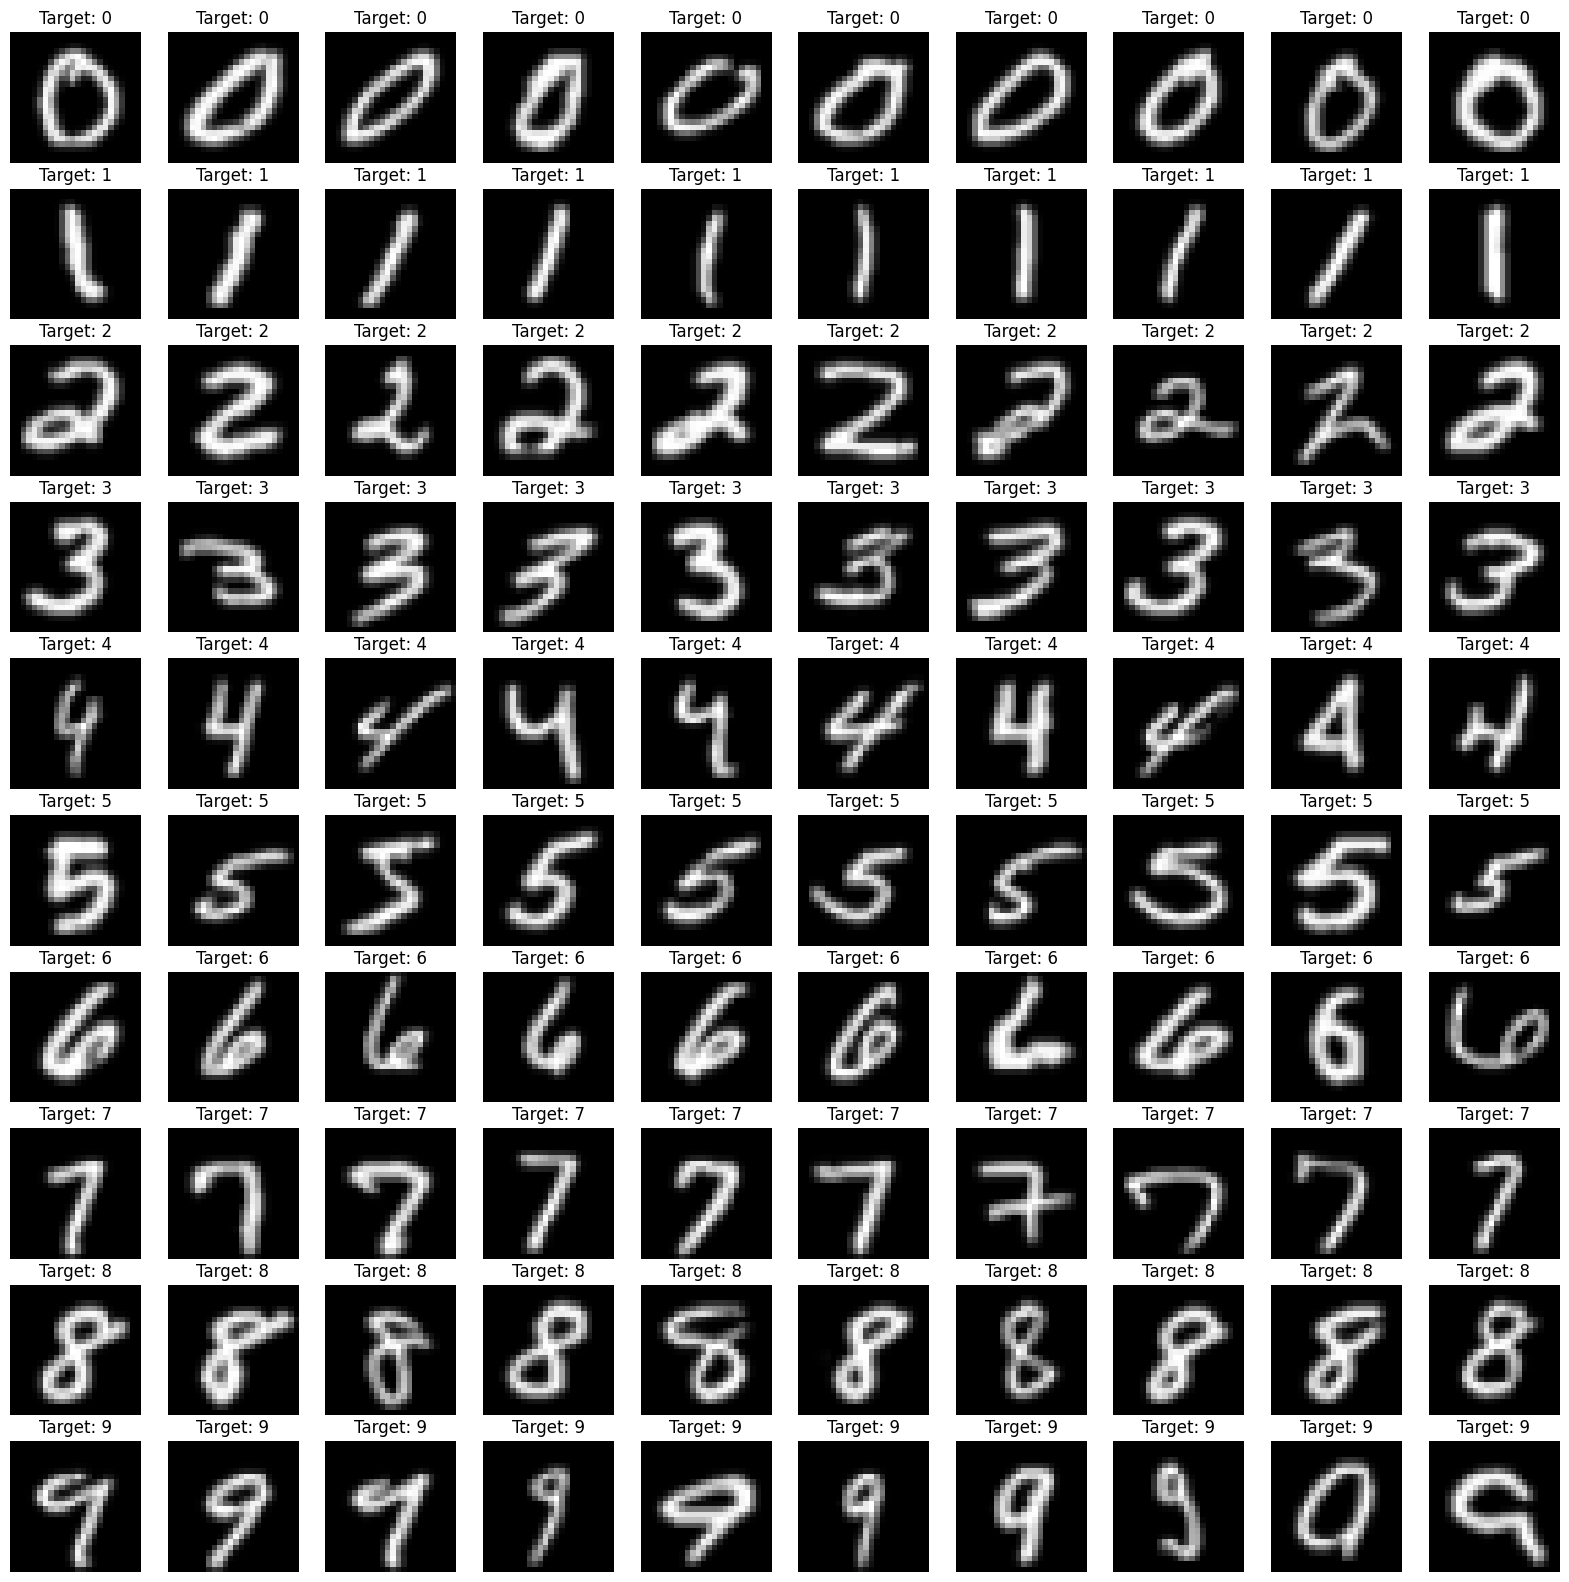

In [5]:
# Define the list of possible target values (0 to 9)
targets = list(range(10))
t = []
f = []
# Plot 10 random samples for each target digit
plt.figure(figsize=(20, 20))
for i, target in enumerate(targets):
    # Get indices of all samples with the target digit
    indices = np.where(data['targets'] == target)[0]
    # Randomly select 100 indices
    indices = np.random.choice(indices, size=100, replace=False)
    t.extend([target] * 100)
    f.extend(data['features'][indices])
    # Randomly select 10 indices from the selected 100
    indices = np.random.choice(indices, size=10, replace=False)
    # Plot the selected samples
    for j, idx in enumerate(indices):
        plt.subplot(10, 10, i*10+j+1)
        plt.imshow(data['features'][idx], cmap='gray')
        plt.axis('off')
        plt.title('Target: {}'.format(target))
plt.show()

In [32]:
# t abd f are the target and feature list
# convert the list to numpy array
t = np.array(t)
f = np.array(f)
f.shape, t.shape

((1000, 24, 24), (1000,))

In [8]:
def knn_grayscale(n, images, targets):
    # Convert the images to grayscale and flatten them
    feature = []
    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        elif len(img.shape) == 2:
            pass
        else:
            raise ValueError("Unexpected image shape: {}".format(img.shape))
        feature.append(img.flatten())
    
    # Split the data into training and testing setsDA
    X_train, X_test, y_train, y_test = train_test_split(feature, targets, test_size=0.2, random_state=0)

    # Train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)

    # Predict the target values for the test data and calculate the accuracy
    y_pred = knn.predict(X_test)
    print("Accuracy od GrayScale when k={}: {:.2f}%".format(n, accuracy_score(y_test, y_pred) * 100))
    
    return knn


In [9]:
knn_gray_1 = knn_grayscale(1, f, t)
knn_gray_5 = knn_grayscale(5, f, t)

Accuracy od GrayScale when k=1: 88.50%
Accuracy od GrayScale when k=5: 88.50%


In [10]:
def knn_hog(n, images, targets):
    # Convert the images to grayscale and flatten them
    hog_feature = []
    for img in images:
        # Normalize the image to 0-1 range
        float_image = np.float32(img) / 255.0
        # Calculate the gradients using Sobel operator
        Gx = cv.Sobel(float_image, cv.CV_32F, 1, 0, ksize=1)
        Gy = cv.Sobel(float_image, cv.CV_32F, 0, 1, ksize=1)
        # Calculate gradient magnitude and direction (in degrees)
        magnitude, angle_degrees = cv.cartToPolar(Gx, Gy, angleInDegrees=True)
        winSize = (24,24)
        blockSize = (16,16)
        blockStride = (8,8)
        cellSize = (8,8)
        nbins = 9
        derivAperture = 1
        winSigma = 4.
        histogramNormType = 0
        L2HysThreshold = 2.0000000000000001e-01
        gammaCorrection = 0
        #nlevels = 64
        #hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection, nlevels)
        hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection)
        winStride = (8,8)
        padding = (8,8)
        locations = ((0,0),) #run at position (0,0) of the image
        hog_feature.append(hog.compute(img,winStride,padding,locations))
    
        # print("HOG feature: \n", hog_feature)
        # number_of_features = hog_feature.shape  
        # print("Number of Features: ", number_of_features)
        # print("This is from 9 histo values x 4 per 16x16 block x 4 such blocks per 24x24 image: ", 9*4*4)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(hog_feature, targets, test_size=0.2, random_state=0)
    # Train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)

    # Predict the target values for the test data and calculate the accuracy
    y_pred = knn.predict(X_test)
    print("Accuracy of HOG when k={}: {:.2f}%".format(n, accuracy_score(y_test, y_pred) * 100))
    
    return knn

In [11]:
knn_hog_1 = knn_hog(1, f, t)
knn_hog_5 = knn_hog(5, f, t)

Accuracy of HOG when k=1: 95.50%
Accuracy of HOG when k=5: 94.00%


In [12]:
# get image from the img20 folder  (18*20)
import os
x1 = []
y1 =[]
for i in range(10):
    for j in range(1, 3):
        img_path = 'img20/{}_{}.png'.format(i, j)
        if os.path.exists(img_path):
            img = cv.imread(img_path)
            img = cv.resize(img, (24, 24))
            x1.append(img)
            y1.append(i)

# convert the list to numpy array
y1 = np.array(y1)
x1 = np.array(x1)

knn_hog_my = knn_hog(1, x1, y1)

Accuracy of HOG when k=1: 25.00%


In [13]:
# get image from the img20 folder  (18*20)
import os
x2 = []
y2 =[]
for i in range(10):
    for j in range(0, 2):
        img_path = 'img20_50/{}_{}.png'.format(i, j)
        if os.path.exists(img_path):
            img = cv.imread(img_path)
            img = cv.resize(img, (24, 24))
            x2.append(img)
            y2.append(i)

# convert the list to numpy array
y2 = np.array(y2)
x2 = np.array(x2)

knn_hog_my = knn_hog(1, x2, y2)

Accuracy of HOG when k=1: 50.00%


In [14]:
x3 = []
y3 =[]
for i in range(0,4):
    img_path = 'img4_5d/5_{}.png'.format(i)
    if os.path.exists(img_path):
        img = cv.imread(img_path)
        img = cv.resize(img, (24, 24))
        x3.append(img)
        y3.append(5)

# convert the list to numpy array
y3 = np.array(y3)
x3 = np.array(x3)

knn_hog_my = knn_hog(1, x3, y3)

Accuracy of HOG when k=1: 100.00%


In [33]:
def Thresholding(img):
    for i in img:
        gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        threshold_value, threshold_image = cv.threshold(gray_image, threshold, 255, cv.THRESH_BINARY)
        number_labels, labels_matrix = cv.connectedComponents(image = threshold_image, connectivity = 8)
        threshold_value, threshold_image1 = cv.threshold(gray_image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)



In [38]:
digit_images = []
for i in range(len(f)):
    #Threshold the image into a binary image of black or white only (2 colors)
    gray_image = f[i]
    threshold_value, threshold_image = cv.threshold(gray_image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    # Choose the connectivity type
    number_labels, labels_matrix, stats_matrix, centroids_matrix = cv.connectedComponentsWithStats(threshold_image, connectivity=8)
    # Find the largest component
    largest_component = np.argmax(stats_matrix[1:,4]) + 1
    # Find the bounding box of the largest component
    x, y, w, h, area = stats_matrix[largest_component]
    # Crop the image to the bounding box of the largest component
    cropped_image = gray_image[y:y+h, x:x+w]
    # Resize the image to 24x24
    resized_image = cv.resize(cropped_image, (24, 24))
    digit_images.append(resized_image)

digit_images = np.array(digit_images)

knn_hog_my = knn_hog(1, digit_images, t)


Accuracy of HOG when k=1: 91.00%
